In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import json
import psycopg2

In [2]:

with open('db_config.json') as file:
    db_config = json.load(file)


engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:5432/{db_config["dbname"]}')

# Leer los datos de la tabla en un DataFrame de Pandas
candidatos = pd.read_sql('SELECT * FROM candidatos', engine)

print(candidatos.head())  # Muestra las primeras filas del DataFrame para verificar


   first_name   last_name                      email application_date  \
0  Bernadette   Langworth        leonard91@yahoo.com       26/02/2021   
1      Camryn    Reynolds        zelda56@hotmail.com        9/09/2021   
2       Larue      Spinka   okey_schultz41@gmail.com       14/04/2020   
3        Arch      Spinka     elvera_kulas@yahoo.com        1/10/2020   
4       Larue  Altenwerth  minnie.gislason@gmail.com       20/05/2020   

   country  yoe  seniority                         technology  \
0   Norway    2     Intern                      Data Engineer   
1   Panama   10     Intern                      Data Engineer   
2  Belarus    4  Mid-Level                     Client Success   
3  Eritrea   25    Trainee                          QA Manual   
4  Myanmar   13  Mid-Level  Social Media Community Management   

   code_challenge_score  technical_interview_score  
0                     3                          3  
1                     2                         10  
2          

Vamos a revisar la estructura general del dataset

In [3]:
candidatos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   first_name                 50000 non-null  object
 1   last_name                  50000 non-null  object
 2   email                      50000 non-null  object
 3   application_date           50000 non-null  object
 4   country                    50000 non-null  object
 5   yoe                        50000 non-null  int64 
 6   seniority                  50000 non-null  object
 7   technology                 50000 non-null  object
 8   code_challenge_score       50000 non-null  int64 
 9   technical_interview_score  50000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.8+ MB


Most of the data types are suitable for the corresponding columns. However, for a more efficient handling of dates, it would be advisable to convert the Application Date column from object to datetime.

In [4]:
candidatos['application_date'] = pd.to_datetime(candidatos['application_date'])

candidatos.dtypes

C:\Users\JSLV3\AppData\Local\Temp\ipykernel_12004\1841470155.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  candidatos['application_date'] = pd.to_datetime(candidatos['application_date'])


first_name                           object
last_name                            object
email                                object
application_date             datetime64[ns]
country                              object
yoe                                   int64
seniority                            object
technology                           object
code_challenge_score                  int64
technical_interview_score             int64
dtype: object

In [5]:
candidatos.describe()

,application_date,yoe,code_challenge_score,technical_interview_score
count,50000,50000.000000,50000.000000,50000.000000
mean,2020-04-03 23:04:14.592000,15.286980,4.996400,5.003880
min,2018-01-01 00:00:00,0.000000,0.000000,0.000000
25%,2019-02-17 00:00:00,8.000000,2.000000,2.000000
50%,2020-04-06 00:00:00,15.000000,5.000000,5.000000
75%,2021-05-21 00:00:00,23.000000,8.000000,8.000000
max,2022-07-04 00:00:00,30.000000,10.000000,10.000000
std,NaN,8.830652,3.166896,3.165082


The statistical analysis of the candidate dataset shows a wide range of years of experience, ranging from 0 to 30 years, with an average of 15 years, indicating a diverse mix of levels of experience. Both the scores of the code challenge and those of the technical interview have an average of 5 out of 10, which reflects an equitable distribution of technical skills among candidates

In [6]:
missing = candidatos.isnull().sum()
missing = missing[missing > 0]

missing

Series([], dtype: int64)

There is no missing data in any of the columns of the data set. Each column is completely populated, which indicates that the data set is complete

In [7]:
candidatos.isnull().sum()

first_name                   0
last_name                    0
email                        0
application_date             0
country                      0
yoe                          0
seniority                    0
technology                   0
code_challenge_score         0
technical_interview_score    0
dtype: int64

In [8]:
candidatos.duplicated().sum()

0

There are no duplicate rows in the data set

#### Entendamos a nuestros candidatos:

1. Observemos de donde provienen nuestros candidatos:

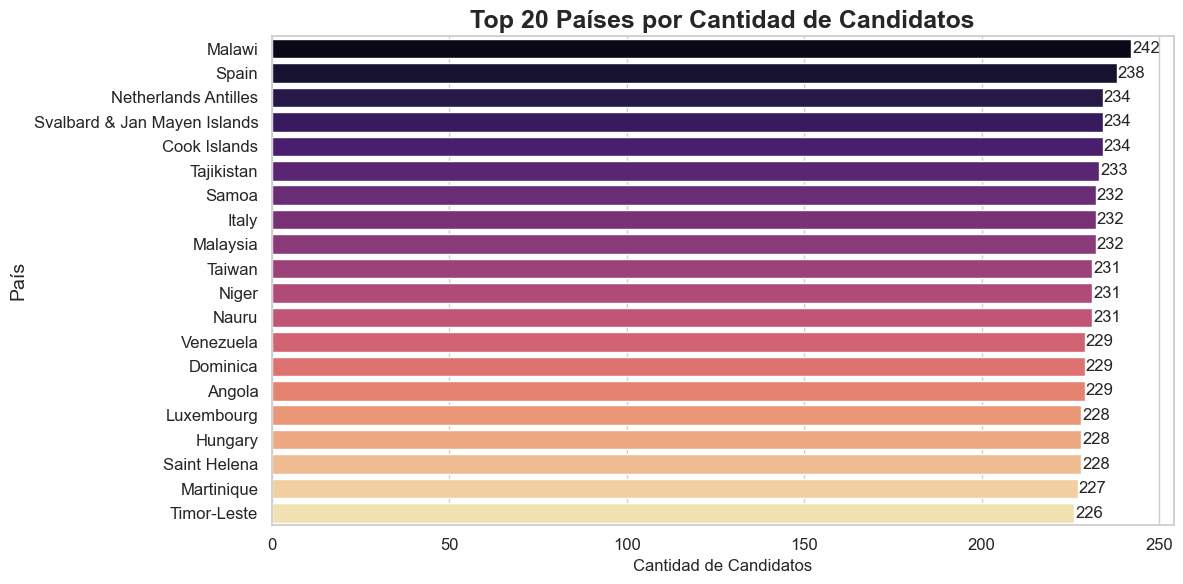

In [9]:
top_countries = candidatos['country'].value_counts().head(20)

sns.set(style="whitegrid", context="notebook", palette="muted")
plt.figure(figsize=(12, 6))

barplot = sns.barplot(x=top_countries.values, y=top_countries.index, hue=top_countries.index,
                      palette=sns.color_palette("magma", n_colors=len(top_countries)), dodge=False)


plt.legend([],[], frameon=False)
plt.title('Top 20 Países por Cantidad de Candidatos', fontsize=18, fontweight='bold')
plt.xlabel('Cantidad de Candidatos', fontsize=12)
plt.ylabel('País', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for p in barplot.patches:
    width = p.get_width()  
    plt.text(width + 0.3, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center', fontsize=12)

plt.tight_layout()
plt.show()



Podemos observar los países que son fuentes principales de candidatos, lo cual podría indicar regiones con un vibrante mercado laboral en el sector tecnológico. Esto puede ser útil para estrategias de reclutamiento dirigidas, especialmente si la empresa está interesada en captar talento global o diversificar su fuerza laboral con perspectivas internacionales.

¿Qué niveles de seniority encontramos?

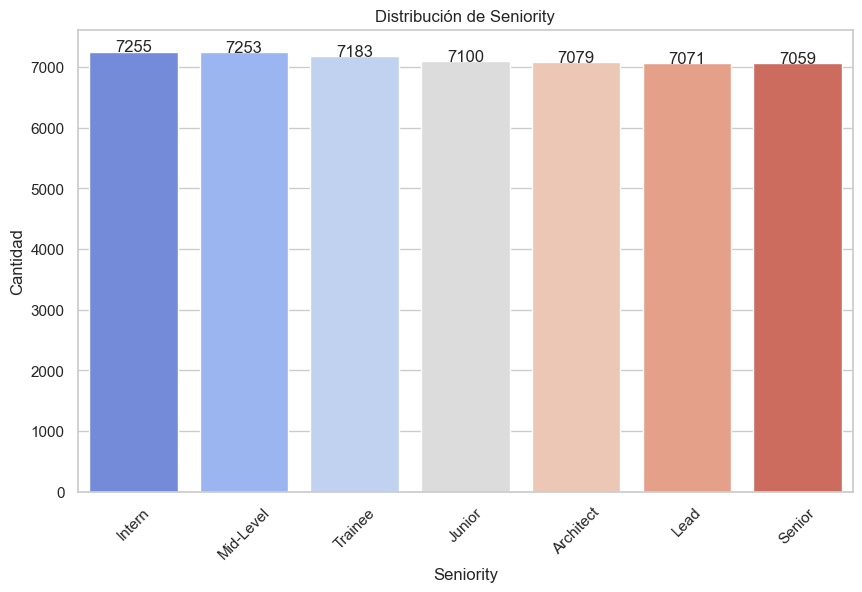

In [10]:
seniority_counts = candidatos['seniority'].value_counts()

plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=seniority_counts.index, y=seniority_counts.values,
                      hue=seniority_counts.index, dodge=False, palette="coolwarm")
plt.legend([],[], frameon=False) 

plt.title('Distribución de Seniority')
plt.xlabel('Seniority')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

for p in barplot.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.0f}'.format(height), ha="center")

plt.show()

Esta visualización nos permite identificar qué niveles de experiencia predominan en el pool de talento, ofreciendo una visión clara de la composición de experiencia en la base de datos de candidatos

¿Estos niveles de seniority influyen en su rendimeinto en las pruebas?

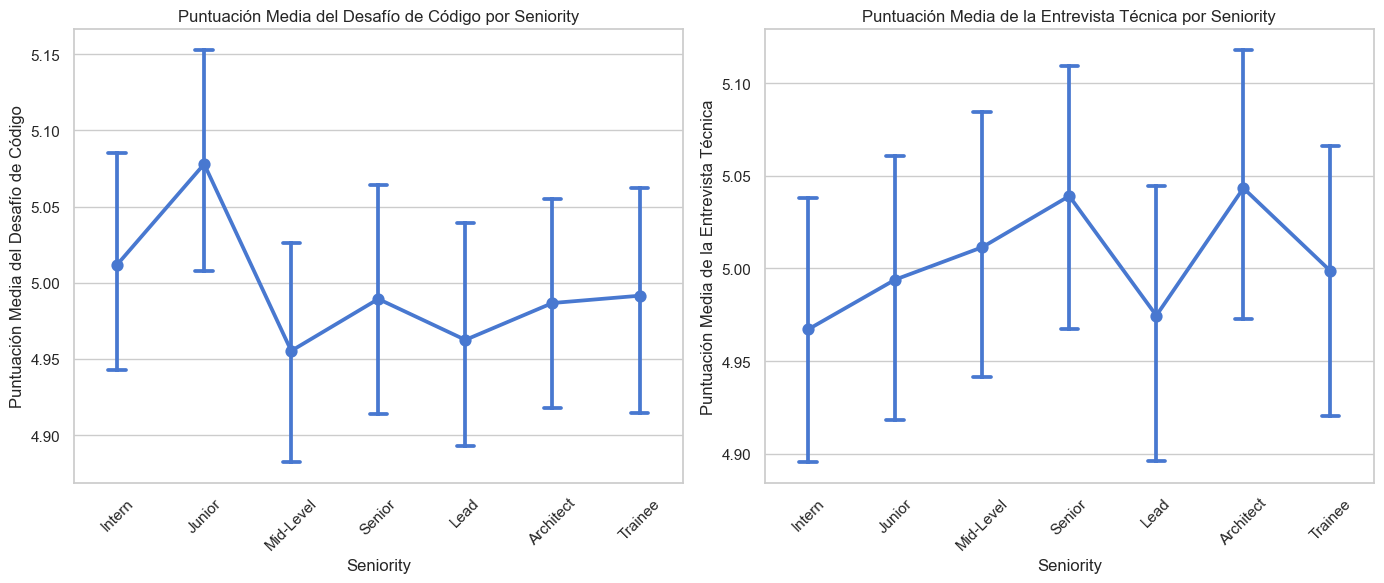

In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

sns.pointplot(x='seniority', y='code_challenge_score', data=candidatos, capsize=.2, 
              order=['Intern', 'Junior', 'Mid-Level', 'Senior', 'Lead', 'Architect', 'Trainee'])
plt.title('Puntuación Media del Desafío de Código por Seniority')
plt.xlabel('Seniority')
plt.ylabel('Puntuación Media del Desafío de Código')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)

sns.pointplot(x='seniority', y='technical_interview_score', data=candidatos, capsize=.2, 
              order=['Intern', 'Junior', 'Mid-Level', 'Senior', 'Lead', 'Architect', 'Trainee'])
plt.title('Puntuación Media de la Entrevista Técnica por Seniority')
plt.xlabel('Seniority')
plt.ylabel('Puntuación Media de la Entrevista Técnica')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Los gráficos de puntos revelan que las puntuaciones medias tanto en desafíos de código como en entrevistas técnicas no siguen una tendencia clara de mejora con niveles de seniority más altos, lo que sugiere que la experiencia por sí sola no determina un mejor rendimiento en estas evaluaciones. 

¿Son los años de experiencia (YOE) y el nivel de seniority indicadores confiables del rendimiento en desafíos de código y entrevistas técnicas durante el proceso de selección?

In [12]:
# Para investigar la correlación entre YOE/Seniority y las puntuaciones, primero necesitamos codificar las categorías de Seniority en valores numéricos
# Vamos a asignar valores numéricos a cada nivel de Seniority para poder correlacionarlos
seniority_mapping = {'Intern': 1, 'Junior': 2, 'Mid-Level': 3, 'Senior': 4, 'Lead': 5, 'Manager': 6, 'Trainee': 0}

# Aplicar el mapeo al DataFrame
candidatos['Seniority Level'] = candidatos['seniority'].map(seniority_mapping)

# Ahora calcularemos la correlación entre YOE, Seniority Level, Code Challenge Score y Technical Interview Score
correlation_matrix = candidatos[['yoe', 'Seniority Level', 'code_challenge_score', 'technical_interview_score']].corr()

correlation_matrix


,yoe,Seniority Level,code_challenge_score,technical_interview_score
yoe,1.000000,0.000670,0.005871,-0.005878
Seniority Level,0.000670,1.000000,-0.005127,0.001764
code_challenge_score,0.005871,-0.005127,1.000000,-0.002373
technical_interview_score,-0.005878,0.001764,-0.002373,1.000000


YOE (Años de Experiencia) y Puntuaciones: Existe una correlación muy baja tanto con la puntuación del desafío de código (0.005871) como con la puntuación de la entrevista técnica (-0.005878). Esto sugiere que el número de años de experiencia de un candidato no tiene una relación directa o significativa con su rendimiento en estas evaluaciones.

Seniority Level y Puntuaciones: Similar a YOE, la correlación entre el nivel de seniority y las puntuaciones en desafíos de código (-0.005127) y entrevistas técnicas (0.001764) también es muy baja. Esto indica que el nivel de seniority por sí solo no es un predictor fuerte del éxito en los desafíos de código o en las entrevistas técnicas.

In [13]:
# Calculamos el top de tecnologías por cantidad de candidatos para verificar los datos previos
top_tech = candidatos['technology'].value_counts().head(15)

top_tech


technology
Game Development                     3818
DevOps                               3808
Social Media Community Management    2028
System Administration                2014
Mulesoft                             1973
Development - Backend                1965
Development - FullStack              1961
Adobe Experience Manager             1954
Data Engineer                        1951
Security                             1936
Development - CMS Frontend           1934
Business Intelligence                1934
Database Administration              1933
Client Success                       1927
Design                               1906
Name: count, dtype: int64

La distribución del top de tecnologías por cantidad de candidatos revela las áreas de especialización más populares y buscadas entre los postulantes. Las tecnologías que lideran el ranking sugieren una alta demanda o un interés significativo en campos específicos, lo cual puede ser indicativo de tendencias actuales en el mercado laboral tecnológico.

¿Cómo varía el rendimiento en desafíos de código y entrevistas técnicas entre las diferentes áreas tecnológicas más demandadas?

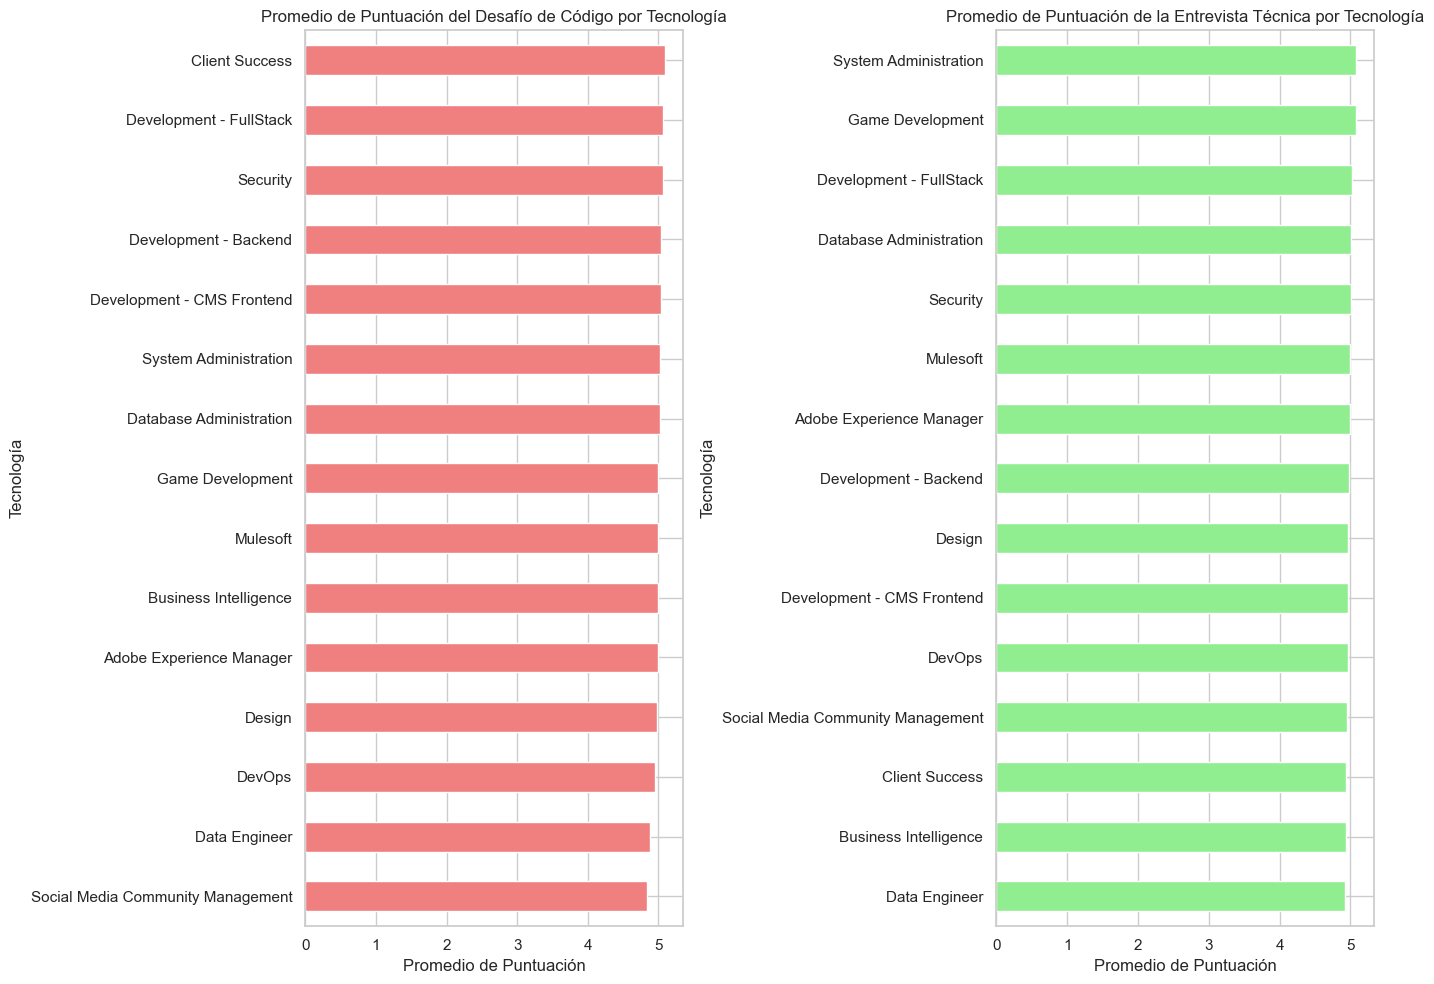

In [14]:
# Calculando la media de puntuaciones por tecnología

tech_scores = candidatos.groupby('technology')[['code_challenge_score', 'technical_interview_score']].mean().sort_values(by='code_challenge_score', ascending=False)

# Filtrando para incluir solo las tecnologías top en el análisis
tech_scores_top = tech_scores[tech_scores.index.isin(top_tech.index)]

# Creando el gráfico
plt.figure(figsize=(14, 10))

# Puntuación del Desafío de Código
plt.subplot(1, 2, 1)
tech_scores_top['code_challenge_score'].sort_values().plot(kind='barh', color='lightcoral')
plt.title('Promedio de Puntuación del Desafío de Código por Tecnología')
plt.xlabel('Promedio de Puntuación')
plt.ylabel('Tecnología')

# Puntuación de la Entrevista Técnica
plt.subplot(1, 2, 2)
tech_scores_top['technical_interview_score'].sort_values().plot(kind='barh', color='lightgreen')
plt.title('Promedio de Puntuación de la Entrevista Técnica por Tecnología')
plt.xlabel('Promedio de Puntuación')
plt.ylabel('Tecnología')

plt.tight_layout()
plt.show()


Observamos que algunas tecnologías, aunque populares en términos de cantidad de candidatos, presentan variaciones significativas en las puntuaciones promedio de desafíos de código y entrevistas técnicas. Esto sugiere que la popularidad de una tecnología no necesariamente se traduce en un alto nivel de competencia técnica entre los candidatos. La preparación y habilidades demostradas en desafíos y entrevistas pueden variar ampliamente, lo que resalta la importancia de un enfoque individualizado en el proceso de selección, más allá de la simple demanda de habilidades en el mercado.

#### ¿Como funcionan las pruebas?

In [15]:
# Verificar el rango de las puntuaciones para confirmar si varían de 0 a 10
min_code_challenge_score = candidatos['code_challenge_score'].min()
max_code_challenge_score = candidatos['code_challenge_score'].max()

min_technical_interview_score = candidatos['technical_interview_score'].min()
max_technical_interview_score = candidatos['technical_interview_score'].max()

(min_code_challenge_score, max_code_challenge_score), (min_technical_interview_score, max_technical_interview_score)


((0, 10), (0, 10))

##### Identificación de Candidatos Contratados Basada en Evaluaciones Técnicas

Para identificar a los candidatos potencialmente contratados dentro de nuestro conjunto de datos, implementamos un enfoque basado en el análisis de puntuaciones obtenidas en dos evaluaciones clave: desafíos de código y entrevistas técnicas. Establecimos un umbral de aprobación, definiendo que las puntuaciones iguales o superiores a 7 (en una escala de 0 a 10) en ambas evaluaciones indican un rendimiento satisfactorio que califica a los candidatos como "Contratados".

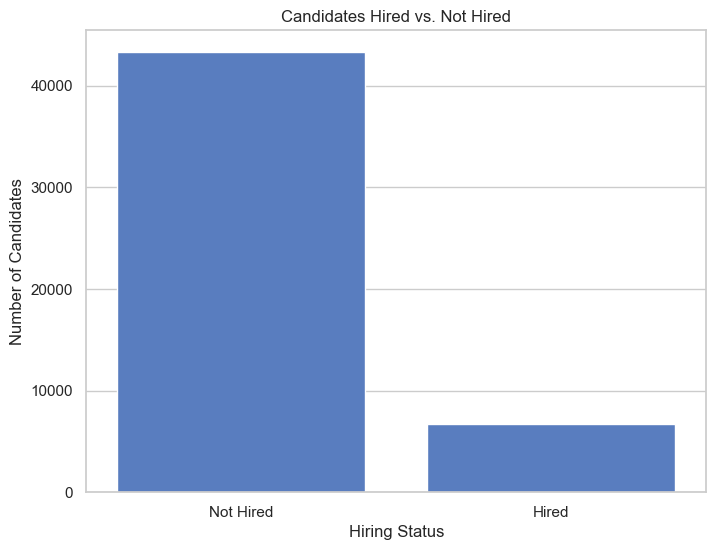

Hired
Not Hired    43302
Hired         6698
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'candidatos' es tu DataFrame y ya has importado las bibliotecas necesarias
# Actualizar la columna 'Hired' para ser booleana directamente
candidatos['Hired'] = (candidatos['code_challenge_score'] >= 7) & (candidatos['technical_interview_score'] >= 7)

# Para la visualización, puedes usar una conversión temporal para mostrar las etiquetas
# Crear una serie temporal con las etiquetas en inglés para la visualización
hired_labels = candidatos['Hired'].map({True: 'Hired', False: 'Not Hired'})

plt.figure(figsize=(8, 6))
sns.countplot(x=hired_labels)
plt.title('Candidates Hired vs. Not Hired')
plt.xlabel('Hiring Status')
plt.ylabel('Number of Candidates')
# Ajuste las etiquetas del eje x si es necesario, dependiendo de cómo seaborn maneje las etiquetas automáticamente
# plt.xticks(ticks=[0, 1], labels=['Not Hired', 'Hired'])

plt.show()

# Si necesitas mostrar la cuenta de candidatos contratados vs. no contratados con las nuevas etiquetas
print(hired_labels.value_counts())




Aplicamos nuestro dataset la clasificacion a los candidatos en "Contratados" y "No Contratados", como una nueva columna, permitiéndonos cuantificar y visualizar la proporción de candidatos que potencialmente cumplen con los requisitos de contratación basados en su desempeño en evaluaciones técnicas.


#### identificar aparte de las pruebas que mas podria infulir o ver tendencias en los demas columnas de contrados a ver que si hay alguna similitud

In [17]:
# Asumiendo que la columna 'Hired' es booleana y True indica que el candidato ha sido contratado
# Filtrar el DataFrame para incluir solo a los candidatos contratados
contratados = candidatos[candidatos['Hired']]

# Calcular las puntuaciones promedio de los contratados para 'code_challenge_score' y 'technical_interview_score'
puntuaciones_contratados_promedio = contratados[['code_challenge_score', 'technical_interview_score']].mean()

puntuaciones_contratados_promedio


code_challenge_score         8.500000
technical_interview_score    8.479248
dtype: float64

Estos resultados muestran que los candidatos contratados, en promedio, no solo cumplen con el criterio mínimo de puntuación (mayor o igual a 7) sino que lo superan significativamente, lo cual indica un alto nivel de competencia en sus habilidades técnicas evaluadas por estos criterios.

aqui la de contratados x senority

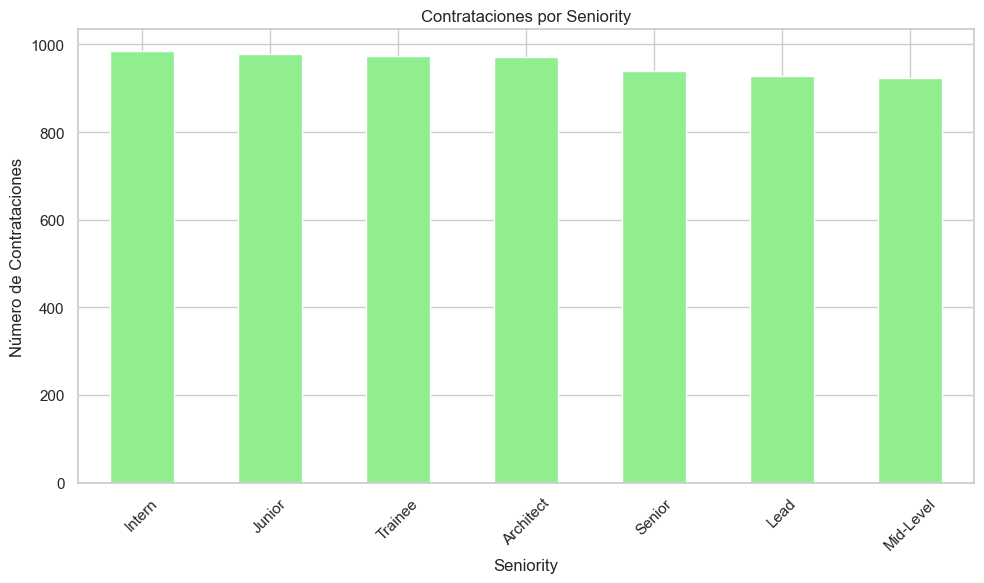

In [18]:
# Agrupar por seniority y estado de contratación, y contar el número de contrataciones
hires_by_seniority = candidatos[candidatos['Hired'] == True].groupby('seniority').size().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
hires_by_seniority.plot(kind='bar', color='lightgreen')
plt.title('Contrataciones por Seniority')
plt.xlabel('Seniority')
plt.ylabel('Número de Contrataciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
# Análisis de la relación entre YOE, Seniority y las puntuaciones para los contratados
yoe_seniority_scores_contratados = contratados.groupby('seniority').agg({
    'yoe': 'mean',
    'code_challenge_score': 'mean',
    'technical_interview_score': 'mean'
}).reset_index()

yoe_seniority_scores_contratados


,seniority,yoe,code_challenge_score,technical_interview_score
0,Architect,15.010299,8.488157,8.434604
1,Intern,15.134010,8.511675,8.509645
2,Junior,15.433982,8.459570,8.472876
3,Lead,15.622174,8.446717,8.511302
4,Mid-Level,15.445887,8.544372,8.495671
5,Senior,15.399361,8.528222,8.483493
6,Trainee,15.020555,8.522097,8.449126


Comparando estos resultados con el análisis realizado para el conjunto total de candidatos, observamos que:

Los años de experiencia promedio son similares entre los contratados y el conjunto total, manteniéndose alrededor de 15 años en promedio para todos los niveles de seniority.
Las puntuaciones promedio tanto en desafíos de código como en entrevistas técnicas son más altas entre los contratados, como era de esperarse dado el criterio de selección (puntuaciones >= 7 para ser considerado contratado). Esto contrasta con las puntuaciones promedio más bajas observadas en el conjunto total de candidatos, lo que indica que, efectivamente, las puntuaciones son un factor determinante para la contratación.
Dentro de los contratados, no hay grandes diferencias en las puntuaciones promedio entre los diferentes niveles de seniority, lo que sugiere que la habilidad demostrada a través de las puntuaciones en desafíos de código y entrevistas técnicas es consistente a través de los niveles de seniority entre aquellos que son contratados.

Tasa de contratación por seniority

In [21]:
# Contar el número total de candidatos por nivel de seniority
total_candidates_by_seniority = candidatos['seniority'].value_counts()

# Contar el número de candidatos contratados por nivel de seniority
hired_candidates_by_seniority = candidatos[candidatos['Hired'] == True]['seniority'].value_counts()

# Calcular la tasa de contratación por seniority
hiring_rate_by_seniority = (hired_candidates_by_seniority / total_candidates_by_seniority).sort_values(ascending=False)

hiring_rate_by_seniority


seniority
Junior       0.137606
Architect    0.137166
Intern       0.135768
Trainee      0.135459
Senior       0.133022
Lead         0.131382
Mid-Level    0.127396
Name: count, dtype: float64

Estas tasas sugieren que, aunque hay una competencia significativa a través de todos los niveles de seniority, los candidatos en los niveles de Junior, Architect e Intern tienen ligeramente mayores tasas de éxito en el proceso de selección. La tasa de contratación tiene tasas de contratación relativamente similares, aunque con ligeras variaciones entre ellos.

tecnoogias:

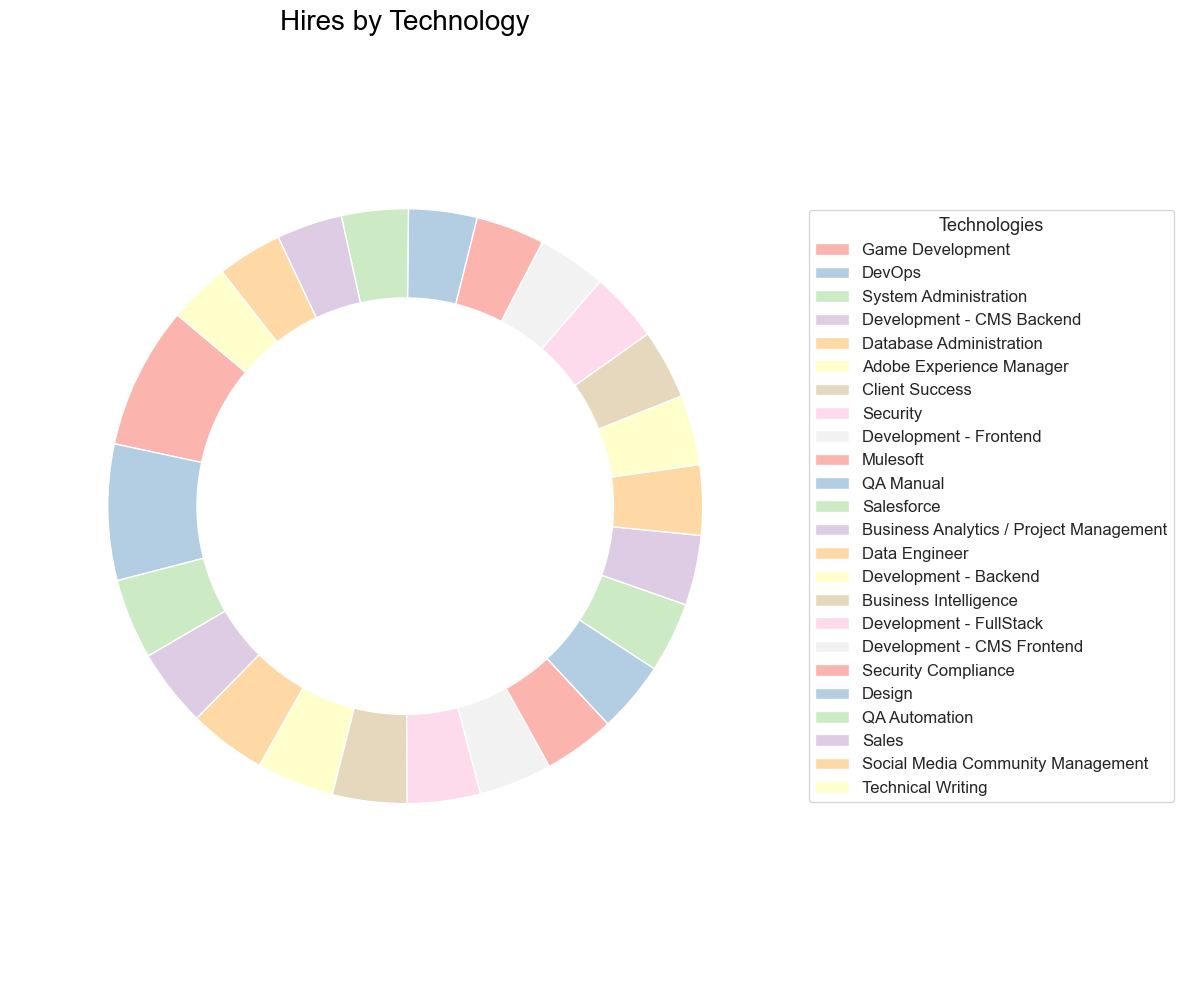

In [22]:
technologies_hired = contratados['technology'].value_counts()

# Configura la paleta de colores que quieres usar
colors = plt.cm.Pastel1.colors  # Paleta de colores

plt.figure(figsize=(12, 10))  # Tamaño de la figura

# Función para calcular el número absoluto a partir del porcentaje
def absolute_value(val):
    a = np.round(val/100.*technologies_hired.sum(), 0)
    return int(a)

wedges, texts, autotexts = plt.pie(
    technologies_hired, 
    autopct=absolute_value,  # Cambiar a números absolutos en lugar de porcentajes
    colors=colors, 
    startangle=140,
    textprops={'color':"w", 'weight':'bold', 'fontsize':12}  # Propiedades del texto
)

plt.title('Hires by Technology', color='black', fontsize=20)
plt.axis('equal')  # Asegura que el gráfico de pastel se dibuje como un círculo

# Dibuja un círculo en el centro para hacer que parezca una rosquilla
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Ajustar leyenda
plt.legend(wedges, technologies_hired.index, title="Technologies", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title_fontsize='13')

plt.tight_layout()  # Ajustar el layout

plt.show()






Investigamos si ciertas tecnologías son más populares entre los contratados de diferentes niveles de seniority

In [23]:
# Análisis de Tecnologías por Seniority entre los contratados
tecnologia_seniority_contratados = contratados.groupby(['seniority', 'technology']).size().unstack(fill_value=0)

# Para mejor visualización, mostraremos las primeras 10 tecnologías
tecnologia_seniority_contratados_top = tecnologia_seniority_contratados.T.sort_values(by='Senior', ascending=False).head(10).T

tecnologia_seniority_contratados_top


technology,Game Development,DevOps,Development - CMS Backend,Social Media Community Management,Mulesoft,Database Administration,Data Engineer,Development - Backend,Security Compliance,Security
seniority,,,,,,,,,,
Architect,71,66,40,35,40,46,36,31,33,47
Intern,80,76,39,38,40,42,41,49,31,39
Junior,76,80,35,25,36,44,35,28,42,36
Lead,69,64,38,37,32,32,38,39,35,27
Mid-Level,67,65,42,33,39,37,35,29,30,38
Senior,84,74,43,43,43,42,41,41,40,40
Trainee,72,70,47,26,30,39,29,38,39,39


In [24]:
# Calcular el número total de candidatos por tecnología
total_candidates_by_technology = candidatos['technology'].value_counts()

# Calcular el número de candidatos contratados por tecnología
hired_candidates_by_technology = candidatos[candidatos['Hired'] == True]['technology'].value_counts()

# Calcular la tasa de contratación por tecnología
hiring_rate_by_technology = (hired_candidates_by_technology / total_candidates_by_technology).sort_values(ascending=False)

hiring_rate_by_technology


technology
Development - CMS Backend                  0.150903
Database Administration                    0.145887
System Administration                      0.145482
Adobe Experience Manager                   0.144319
Development - Frontend                     0.140964
Client Success                             0.140633
Security                                   0.137397
Salesforce                                 0.136606
QA Manual                                  0.136172
Game Development                           0.135935
Business Analytics / Project Management    0.135783
Security Compliance                        0.134989
Mulesoft                                   0.131779
Business Intelligence                      0.131334
Data Engineer                              0.130702
Design                                     0.130640
DevOps                                     0.129989
Development - CMS Frontend                 0.129783
Development - Backend                      0.129771
D

In [ ]:
# Mapeo de tecnologías a categorías
technology_categories = {
    'Data Engineer': 'Data Engineering',
    'Client Success': 'Client Relations & Management',
    'Sales': 'Client Relations & Management',
    'QA Manual': 'Quality Assurance & Security',
    'QA Automation': 'Quality Assurance & Security',
    'Security': 'Quality Assurance & Security',
    'Security Compliance': 'Quality Assurance & Security',
    'Social Media Community Management': 'Marketing & Communications',
    'Adobe Experience Manager': 'Marketing & Communications',
    'Game Development': 'Development & Engineering',
    'Development - CMS Backend': 'Development & Engineering',
    'Development - CMS Frontend': 'Development & Engineering',
    'Development - Backend': 'Development & Engineering',
    'Development - Frontend': 'Development & Engineering',
    'Development - FullStack': 'Development & Engineering',
    'Mulesoft': 'Systems & Operations',
    'DevOps': 'Systems & Operations',
    'System Administration': 'Systems & Operations',
    'Database Administration': 'Systems & Operations',
    'Business Analytics / Project Management': 'Business & Management Analytics',
    'Business Intelligence': 'Business & Management Analytics',
    'Design': 'Design & Content',
    'Technical Writing': 'Design & Content',
    'Salesforce': 'Platform Specific'
}

# Aplicar el mapeo para crear la nueva columna 'Category'
candidatos['Category'] = candidatos['technology'].map(technology_categories)

# Mostrar las primeras filas para verificar que la nueva columna ha sido añadida correctamente
print(candidatos[['technology', 'Category']].head())


                          technology                       Category
0                      Data Engineer               Data Engineering
1                      Data Engineer               Data Engineering
2                     Client Success  Client Relations & Management
3                          QA Manual   Quality Assurance & Security
4  Social Media Community Management     Marketing & Communications


In [ ]:
# Asumiendo que 'engine' ya está configurado como antes
try:
    candidatos.to_sql('candidates_hired', engine, if_exists='replace', index=False)
    print("La tabla 'candidates_hired' ha sido creada y los datos insertados con éxito.")
except Exception as e:
    print(f"Ocurrió un error al guardar los datos en la base de datos: {e}")



La tabla 'candidates_hired' ha sido creada y los datos insertados con éxito.


In [ ]:
# Configurar la conexión a la base de datos (Asegúrate de usar tus propios valores de configuración)
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:5432/{db_config["dbname"]}')

# Leer los datos de la tabla 'candidates_hired_status' en un DataFrame
candidates_hired = pd.read_sql('SELECT * FROM candidates_hired', engine)

# Mostrar las primeras filas del DataFrame para verificar los datos
print(candidates_hired.head())


   first_name   last_name                      email application_date  \
0  Bernadette   Langworth        leonard91@yahoo.com       2021-02-26   
1      Camryn    Reynolds        zelda56@hotmail.com       2021-09-09   
2       Larue      Spinka   okey_schultz41@gmail.com       2020-04-14   
3        Arch      Spinka     elvera_kulas@yahoo.com       2020-10-01   
4       Larue  Altenwerth  minnie.gislason@gmail.com       2020-05-20   

   country  yoe  seniority                         technology  \
0   Norway    2     Intern                      Data Engineer   
1   Panama   10     Intern                      Data Engineer   
2  Belarus    4  Mid-Level                     Client Success   
3  Eritrea   25    Trainee                          QA Manual   
4  Myanmar   13  Mid-Level  Social Media Community Management   

   code_challenge_score  technical_interview_score  Seniority Level  Hired  \
0                     3                          3              1.0  False   
1             